In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr
import glob
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd
import cmocean.cm as cmo

In [3]:
# get dataset 
data = xr.open_dataset('/work/uo1075/u241321/data/tauuo_1970-2019_assi_dt.nc',decode_times=False)
var = np.mean(data['__xarray_dataarray_variable__'], axis=1)

assi = np.load("/work/uo1075/u241321/data/eemd_t310_assi_Norwegian.npy") # mode(c1-c4), time
# Create time slice from dates
start_time = '1971-07-16'
end_time = '2018-07-16'
y = assi[2,:]

field = var.stack(spatial=('lat','lon')).dropna(dim="spatial") #time,space

from sklearn.linear_model import LinearRegression
def regression(x,y):

    coef = LinearRegression(fit_intercept=True).fit(x.reshape(-1, 1), y.values.reshape(-1, 1)).coef_
    

    return coef


coe = np.zeros((6, field.shape[1]))

# regression, center on 4-47, 44 year (start from 0)

for m in range(0,field.shape[1],1):
        coe[0,m] = regression(y[5:49], field[0:44,m])
        coe[1,m] = regression(y[5:49], field[1:45,m])
        coe[2,m] = regression(y[5:49], field[2:46,m])
        coe[3,m] = regression(y[5:49], field[3:47,m])
        coe[4,m] = regression(y[5:49], field[4:48,m])
        coe[5,m] = regression(y[5:49], field[5:49,m])
       


coe1 = xr.DataArray(coe,  
                    dims=['mode','spatial'],
                    coords=dict(
                        spatial=field.spatial,
                         mode=np.arange(1,7,1))
                    , )
# field = var.stack(spatial=('lat','lon')).dropna(dim="spatial") #time,space
spatial = field .coords["spatial"]
mode = coe1 .coords["mode"]
reg = xr.DataArray(coe1, dims = ["mode","spatial"], coords = {"mode":mode,"spatial":spatial}).unstack()
reg.shape

(6, 90, 150)

In [4]:
reg.to_netcdf("/work/uo1075/u241321/data/reg_zwinds_T_c2_output_44.nc")

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


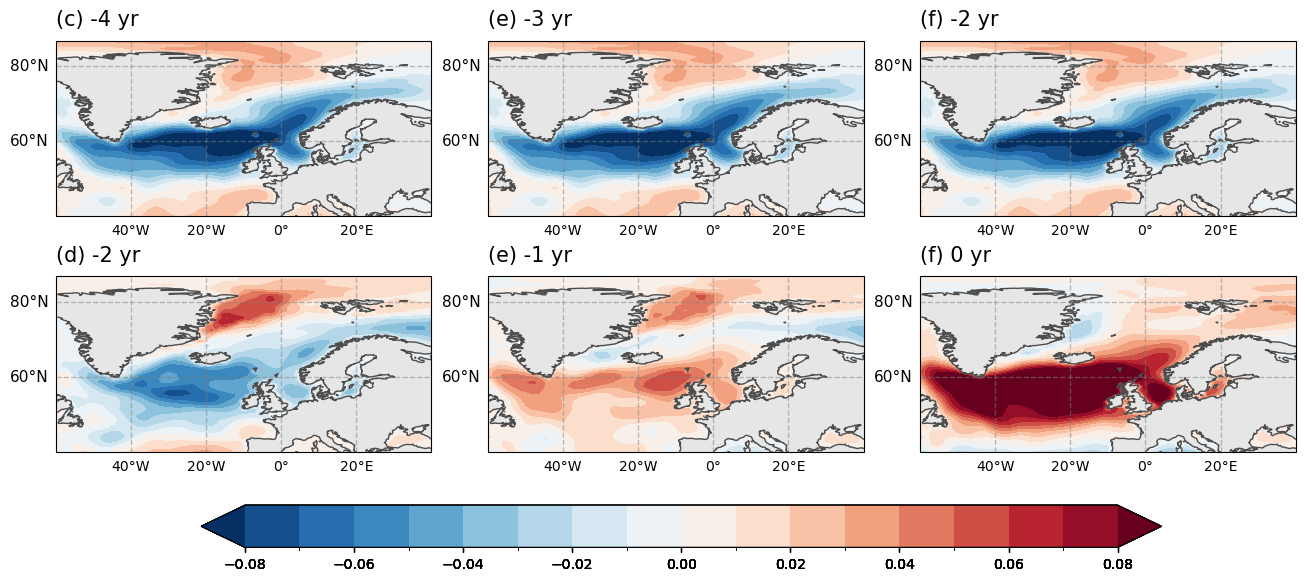

In [5]:
Seas = [reg[0,:], reg[0,:], reg[0,:], reg[2,:],reg[3,:],reg[4,:]]
title = ["(c) -4 yr","(e) -3 yr","(f) -2 yr", "(d) -2 yr",
        "(e) -1 yr","(f) 0 yr"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,14),subplot_kw={'projection': ccrs.PlateCarree()})

plt.subplots_adjust(hspace=-0.72,wspace =0.15)

for i,ax in enumerate(axes.flat):
    
    p = Seas[i].plot.contourf(ax=ax, x='lon', y='lat',
                levels = np.arange(-0.08, 0.09, 0.01),
                              cmap='RdBu_r',
                              extend = 'both', add_colorbar=False, add_labels=False)



    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                                                  edgecolor='0.3',
                                                  facecolor='0.9'))
    ax.set_title(title[i],size = '15', loc = 'left', pad = 11)
#    ax.set_title('',size = '15', loc = 'left', pad = 25)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xlines = True
    gl.ylines = True
    ax.set_extent([-60,40,40,85])
    gl.xlocator = mticker.FixedLocator(np.arange(-80,90,20))
    gl.ylocator = mticker.FixedLocator(np.arange(20,110,20)) #([30,60],180)


    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k','rotation':0}
    gl.ylabel_style = {'size':11,'rotation':0}
    #plt.title('hello', y=1.08)

    cax = fig.add_axes([0.216, 0.28, 0.6, 0.03])
    cb = plt.colorbar(p, cax=cax, orientation='horizontal')

    fig.suptitle('', fontsize=16, y=0.7)  
#     plt.text(0.14,25.5,' ', fontsize=16)
#     plt.text(0.72,25.5,' ', fontsize=16)
plt.show()
# fig.savefig('/work/uo1075/u241321/results/temperature.pdf')

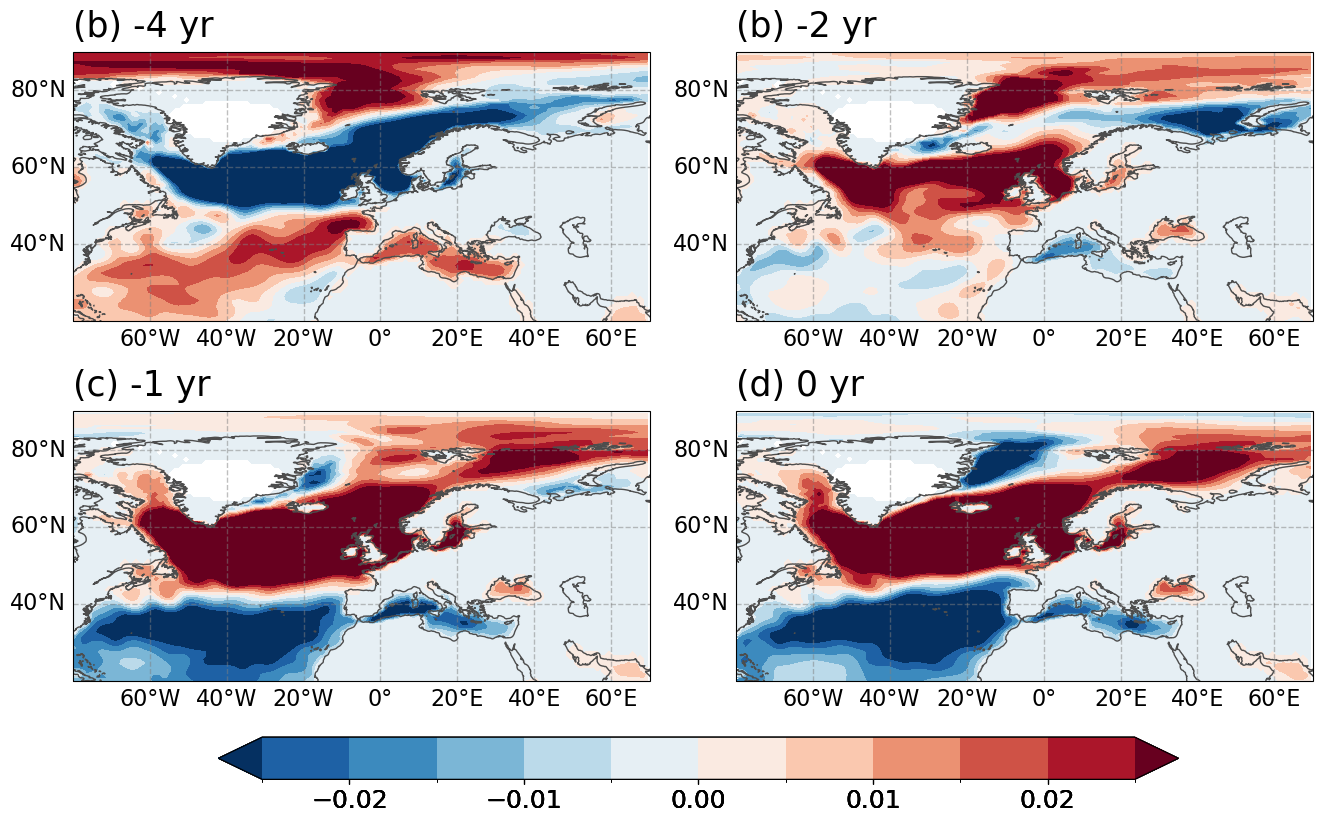

In [6]:
Seas = [reg[0,:],reg[3,:],reg[4,:],reg[5,:]]
title = ["(b) -4 yr","(b) -2 yr",
        "(c) -1 yr","(d) 0 yr"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,14),subplot_kw={'projection': ccrs.PlateCarree()})

plt.subplots_adjust(hspace=-0.5,wspace =0.15)

for i,ax in enumerate(axes.flat):
    
    p = Seas[i].plot.contourf(ax=ax, x='lon', y='lat',
                levels = np.arange(-0.025, 0.03, 0.005),
                              cmap='RdBu_r',
                              extend = 'both', add_colorbar=False, add_labels=False)



    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                                                  edgecolor='0.3',
                                                  facecolor='none'))
    ax.set_title(title[i],size = '25', loc = 'left', pad = 11)
#    ax.set_title('',size = '15', loc = 'left', pad = 25)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xlines = True
    gl.ylines = True
    ax.set_extent([-80,70,20,90])
    gl.xlocator = mticker.FixedLocator(np.arange(-80,90,20))
    gl.ylocator = mticker.FixedLocator(np.arange(20,110,20)) #([30,60],180)


    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 16, 'color': 'k','rotation':0}
    gl.ylabel_style = {'size':16,'rotation':0}
    #plt.title('hello', y=1.08)

    cax = fig.add_axes([0.216, 0.2, 0.6, 0.03])
    cb = plt.colorbar(p, cax=cax, orientation='horizontal')
    cb.ax.tick_params(labelsize=18)
    fig.suptitle('', fontsize=16, y=0.7)  
    fig.suptitle(' ', fontsize=16, y=0.7)  
#     plt.text(0.14,25.5,' ', fontsize=16)
#     plt.text(0.72,25.5,' ', fontsize=16)
plt.show()
fig.savefig('/work/uo1075/u241321/results/result.pdf')

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


IndexError: index 6 is out of bounds for axis 0 with size 6

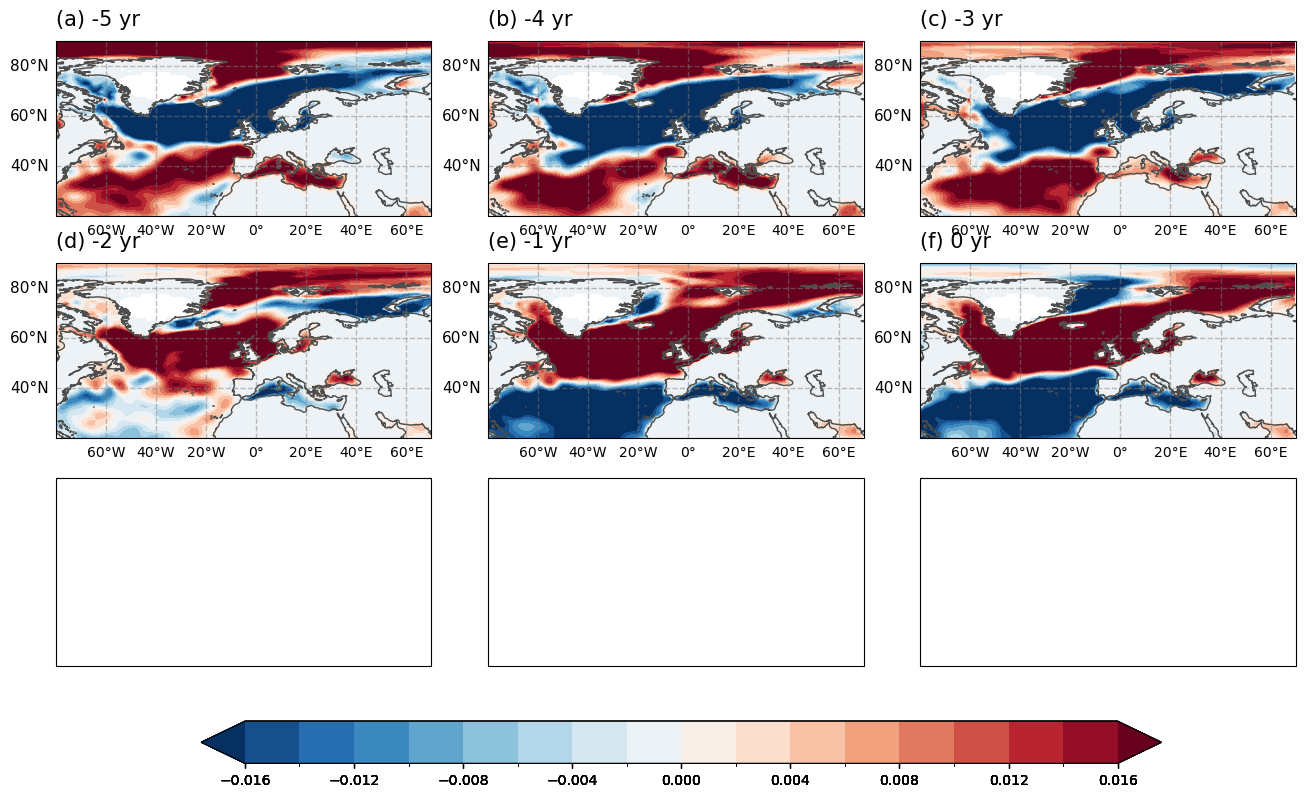

In [7]:
Seas = reg
title = ["(a) -5 yr","(b) -4 yr","(c) -3 yr", "(d) -2 yr",
        "(e) -1 yr","(f) 0 yr","(g) +1 yr",
        "(h) +2 yr","(i) +3 yr"]


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,14),subplot_kw={'projection': ccrs.PlateCarree()})

plt.subplots_adjust(hspace=-0.65,wspace =0.15)

for i,ax in enumerate(axes.flat):
    
    p = Seas[i].plot.contourf(ax=ax, x='lon', y='lat',
                levels = np.arange(-0.016, 0.018, 0.002),
                              cmap='RdBu_r',
                              extend = 'both', add_colorbar=False, add_labels=False)



    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                                                  edgecolor='0.3',
                                                  facecolor='none'))
    ax.set_title(title[i],size = '15', loc = 'left', pad = 11)
#    ax.set_title('',size = '15', loc = 'left', pad = 25)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xlines = True
    gl.ylines = True
    ax.set_extent([-80,70,20,90])
    gl.xlocator = mticker.FixedLocator(np.arange(-80,90,20))
    gl.ylocator = mticker.FixedLocator(np.arange(20,110,20)) #([30,60],180)


    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k','rotation':0}
    gl.ylabel_style = {'size':11,'rotation':0}
    #plt.title('hello', y=1.08)

    cax = fig.add_axes([0.216, 0.2, 0.6, 0.03])
    cb = plt.colorbar(p, cax=cax, orientation='horizontal')

    fig.suptitle(' ', fontsize=16, y=0.7)  
#     plt.text(0.14,25.5,' ', fontsize=16)
#     plt.text(0.72,25.5,' ', fontsize=16)
plt.show()
# fig.savefig('/work/uo1075/u241321/results/result.pdf')